# DistilRoBERTa Emotion Analysis: NLP Case Study on Steam Reviews

This notebook explores [277k+ English Steam reviews for Dead by Daylight (2019–2025)](https://www.kaggle.com/datasets/nicolamustone/steam-reviews-english-dead-by-daylight). We look at how sentiment changes with playtime, how it evolves over patches, and how mood (joy, anger, disgust, etc.) interacts with Steam’s thumbs-up/down.

Copyright © 2025 Nicola Mustone.

Notebook released under **GNU General Public License v3.0 (GPLv3)** - You should have received a copy of the GNU General Public License along with this program. If not, see <https://www.gnu.org/licenses/>.
Datasets released under **MIT License**.

This notebook accompanies the essay: <https://buthonestly.io/programming/distilroberta-emotion-analysis-nlp-case-study/>

## Imports & Global Config

In [2]:
from pathlib import Path
from collections import Counter
import re
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from transformers import AutoTokenizer, AutoModelForSequenceClassification

### Constants and global settings

In [3]:
SEED = 42

DATA_PATH = Path("steam_reviews_381210_english.csv")

NGRAM_SAMPLE_SIZE = 50_000       # for later text analysis
EMOTION_SAMPLE_SIZE = 80_000     # for emotion model comparisons

EMOTION_MODEL_NAME = "j-hartmann/emotion-english-distilroberta-base"

plt.rcParams["figure.figsize"] = (8, 4)
pd.set_option("display.max_colwidth", 200)

np.random.seed(SEED)
torch.manual_seed(SEED)

## 1. Load the dataset

We start by loading the CSV of English-only Steam reviews for Dead by Daylight. Each row is one review with text, a Steam sentiment flag, timestamps, and some author stats (playtime, number of games, etc.).

In [4]:
df = pd.read_csv(DATA_PATH)
df.head()

review  \
0  the Ghoul should be taken out of the game. Just refunded the people who had it. Its way to op and is just some lame anime BS that has no place in a horror game. \r\nalso I play as the killer alot ...   
1                                                                                                                                                                It's a great game if you hate having fun!   
2                                                                                                                                               game is nice, especially w friends. has its ups and downs.   
3                                                                                                                                                                           bubba goes where bubba pleases   
4                                                                                                                                                                                     pls fix ur game bhvr   

   sentiment  purchased  received_for_free  votes_up  votes_funny  \
0          0          1                  0         0            0   
1          1          0                  0         0            0   
2          1          1                  0         0            0   
3          1          1                  0         0            0   
4          0          0                  0         1            0   

  date_created date_updated  author_num_games_owned  author_num_reviews  \
0   2025-11-09   2025-11-09                       0                   6   
1   2025-11-09   2025-11-09                       0                   6   
2   2025-11-09   2025-11-09                       0                   5   
3   2025-11-09   2025-11-09                       0                   5   
4   2025-11-09   2025-11-09                      53                  21   

   author_playtime_forever_min  author_playtime_at_review_min  
0                         6934                           6934  
1                        16347                          16314  
2                         7511                           7481  
3                         3761                           3700  
4                         9045                           8979

## 2. Quick sanity checks

Before doing anything fancy, we inspect the columns, data types, text lengths, and the overall sentiment split. This tells us what we’re working with and catches obvious issues (missing text, weird ranges, etc.).

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277479 entries, 0 to 277478
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   review                         276470 non-null  object        
 1   sentiment                      277479 non-null  int64         
 2   purchased                      277479 non-null  int64         
 3   received_for_free              277479 non-null  int64         
 4   votes_up                       277479 non-null  int64         
 5   votes_funny                    277479 non-null  int64         
 6   date_created                   277479 non-null  datetime64[ns]
 7   date_updated                   277479 non-null  object        
 8   author_num_games_owned         277479 non-null  int64         
 9   author_num_reviews             277479 non-null  int64         
 10  author_playtime_forever_min    277479 non-null  int64         
 11  

In [35]:
# Text length distribution
df["text_len"] = df["review"].astype(str).str.len()
df["text_len"].describe()

count    277479.000000
mean        157.870722
std         448.160816
min           1.000000
25%          11.000000
50%          36.000000
75%         113.000000
max        8000.000000
Name: text_len, dtype: float64

In [36]:
# Sentiment counts and proportions
sentiment_counts = df["sentiment"].value_counts().sort_index()
sentiment_share = df["sentiment"].value_counts(normalize=True).sort_index()

sentiment_counts, sentiment_share

(sentiment
 0     54777
 1    222702
 Name: count, dtype: int64,
 sentiment
 0    0.19741
 1    0.80259
 Name: proportion, dtype: float64)

In [6]:
# Date range
df["date_created"] = pd.to_datetime(df["date_created"])
date_range = df["date_created"].agg(["min", "max"])
date_range

min   2019-07-04
max   2025-11-09
Name: date_created, dtype: datetime64[ns]

## 3. Reviews over time

We bucket reviews by month to see how volume and positivity evolve across the 2019–2025 window. This gives us a simple “emotional timeline” for the game.

In [7]:
df["year_month"] = df["date_created"].dt.to_period("M").dt.to_timestamp()

monthly = (
    df.groupby("year_month")
      .agg(
          review_count=("review", "size"),
          share_positive=("sentiment", "mean"),
      )
      .reset_index()
)

monthly.tail(), monthly.head()

(   year_month  review_count  share_positive
 72 2025-07-01          6294        0.806006
 73 2025-08-01          5321        0.709641
 74 2025-09-01          3764        0.642402
 75 2025-10-01          3691        0.719859
 76 2025-11-01           963        0.703011,
   year_month  review_count  share_positive
 0 2019-07-01          2186        0.828454
 1 2019-08-01           803        0.699875
 2 2019-09-01          1225        0.728163
 3 2019-10-01          2084        0.820537
 4 2019-11-01          6585        0.867882)

## 4. Experience bands (new → master)

Using minutes played at review time, we group players into **new**, **regular**, **veteran**, and **master**. Then we check how likely each group is to recommend the game.

In [8]:
playtime_desc = df["author_playtime_at_review_min"].describe()
playtime_quantiles = df["author_playtime_at_review_min"].quantile([0.25, 0.5, 0.75, 0.9, 0.99])

playtime_desc
playtime_quantiles

0.25      1021.00
0.50      4462.00
0.75     18112.50
0.90     50459.20
0.99    170344.44
Name: author_playtime_at_review_min, dtype: float64

In [9]:
def label_experience(minutes: float) -> str:
    """Bucket players by minutes played at review time."""
    if minutes < 100 * 60:
        return "new"
    elif minutes < 500 * 60:
        return "regular"
    elif minutes < 2_000 * 60:
        return "veteran"
    else:
        return "master"


df["experience"] = df["author_playtime_at_review_min"].fillna(0).apply(label_experience)

experience_counts = df["experience"].value_counts().sort_index()
experience_counts

experience
master       6099
new        153318
regular     77292
veteran     40770
Name: count, dtype: int64

In [10]:
sentiment_by_experience = (
    df.groupby("experience")["sentiment"]
      .mean()
      .sort_index()
)

sentiment_by_experience

experience
master     0.544679
new        0.863512
regular    0.773314
veteran    0.667574
Name: sentiment, dtype: float64

## 5. How positive and negative players talk

Here we define a simple tokenizer and look at the most common unigrams and bigrams in positive vs negative reviews. This gives a first feel for the language players use when they’re happy or frustrated.

In [11]:
PUNCTUATION = set(string.punctuation)
STOPWORDS = ENGLISH_STOP_WORDS


def tokenize(text: str) -> list[str]:
    text = str(text).lower()
    # keep only letters and apostrophes
    tokens = re.findall(r"[a-z']+", text)
    return [t for t in tokens if t not in STOPWORDS and len(t) > 2]


def top_ngrams(texts, n: int = 1, top_k: int = 30):
    counter = Counter()
    for text in texts:
        tokens = tokenize(text)
        for i in range(len(tokens) - n + 1):
            ngram = " ".join(tokens[i:i + n])
            counter[ngram] += 1
    return counter.most_common(top_k)


pos_mask = df["sentiment"] == 1
neg_mask = df["sentiment"] == 0

pos_n = min(NGRAM_SAMPLE_SIZE, pos_mask.sum())
neg_n = min(NGRAM_SAMPLE_SIZE, neg_mask.sum())

pos_sample = df.loc[pos_mask, "review"].sample(pos_n, random_state=SEED)
neg_sample = df.loc[neg_mask, "review"].sample(neg_n, random_state=SEED)

In [12]:
top_pos_uni = top_ngrams(pos_sample, n=1, top_k=20)
top_neg_uni = top_ngrams(neg_sample, n=1, top_k=20)

top_pos_uni, top_neg_uni

([('game', 36588),
  ('fun', 14520),
  ('good', 9308),
  ('play', 8910),
  ('killer', 6107),
  ('friends', 5397),
  ('like', 5301),
  ("it's", 4412),
  ('great', 4210),
  ('just', 4163),
  ('playing', 4144),
  ('love', 4005),
  ('time', 3404),
  ('killers', 3301),
  ('really', 3271),
  ('survivor', 3125),
  ('survivors', 2863),
  ('games', 2453),
  ('people', 2375),
  ('recommend', 2268)],
 [('game', 84917),
  ('killer', 20369),
  ('play', 20246),
  ('just', 16706),
  ('fun', 13593),
  ('killers', 12978),
  ('like', 12181),
  ('time', 10737),
  ('survivor', 10283),
  ('survivors', 10214),
  ("don't", 9850),
  ('playing', 9805),
  ("it's", 9493),
  ('new', 8038),
  ('perks', 8002),
  ('good', 7583),
  ('players', 7539),
  ('devs', 7504),
  ('people', 7181),
  ('community', 6440)])

In [13]:
top_pos_bi = top_ngrams(pos_sample, n=2, top_k=20)
top_neg_bi = top_ngrams(neg_sample, n=2, top_k=20)

top_pos_bi, top_neg_bi

([('good game', 3019),
  ('great game', 2442),
  ('fun game', 2422),
  ('dead daylight', 1568),
  ('play friends', 1535),
  ('game play', 1530),
  ('nea nea', 1526),
  ('game fun', 1279),
  ('love game', 1197),
  ('fun play', 1092),
  ('game great', 1009),
  ('play game', 944),
  ('really fun', 805),
  ('fun friends', 775),
  ('hate game', 705),
  ('playing game', 669),
  ('fun haha', 668),
  ('haha fun', 667),
  ('best game', 642),
  ('pretty good', 597)],
 [('play game', 3689),
  ('dead daylight', 2387),
  ('playing game', 1926),
  ('game fun', 1788),
  ('play killer', 1560),
  ('game play', 1552),
  ('recommend game', 1548),
  ('game just', 1537),
  ('fun game', 1420),
  ('buy game', 1320),
  ('tunnel tunnel', 1144),
  ('good game', 1066),
  ('new players', 1049),
  ('hours game', 1006),
  ('want play', 999),
  ('playing killer', 989),
  ("game it's", 983),
  ('play survivor', 961),
  ('game game', 921),
  ('bad game', 908)])

## 6. Patches as context

Dead by Daylight changes constantly, so we bring in a small patch CSV with version + date. We classify each version as **major**, **minor**, or **patch**, then align it to the monthly sentiment curve.

### Load and classify patches

In [14]:
patches = pd.read_csv("dbd_patches.csv", parse_dates=["date"])

def patch_type_from_version(v: str) -> str:
    v = str(v)
    parts = v.split(".")
    if len(parts) != 3:
        return "other"
    major, minor, patch = parts
    if minor == "0" and patch == "0":
        return "major"
    elif patch == "0":
        return "minor"
    else:
        return "patch"


patches["patch_type"] = patches["version"].apply(patch_type_from_version)

# Align to year-month for joining with reviews
patches["year_month"] = patches["date"].dt.to_period("M").dt.to_timestamp()

# Quick sanity check: how many of each type?
patches["patch_type"].value_counts(), patches.head()

(patch_type
 patch    231
 minor     59
 major      8
 Name: count, dtype: int64,
   version       date patch_type year_month
 0  1.0.1a 2016-06-22      patch 2016-06-01
 1   1.0.2 2016-06-29      patch 2016-06-01
 2  1.0.2a 2016-06-30      patch 2016-06-01
 3  1.0.2b 2016-06-30      patch 2016-06-01
 4  1.0.2c 2016-06-30      patch 2016-06-01)

### Join patch counts to monthly review stats

In [16]:
start_month = df["year_month"].min()
end_month = df["year_month"].max()

patches_window = patches[
    (patches["year_month"] >= start_month)
    & (patches["year_month"] <= end_month)
].copy()

# Count patch types per month
patch_summary = (
    patches_window
    .groupby(["year_month", "patch_type"])["version"]
    .count()
    .unstack(fill_value=0)
    .reset_index()
)

# Merge with monthly review stats
monthly_with_patches = monthly.merge(patch_summary, on="year_month", how="left")

for col in ["major", "minor", "patch"]:
    if col in monthly_with_patches.columns:
        monthly_with_patches[col] = monthly_with_patches[col].fillna(0)

monthly_with_patches.head()

year_month  review_count  share_positive  major  minor  patch
0 2019-07-01          2186        0.828454    0.0    1.0    2.0
1 2019-08-01           803        0.699875    0.0    0.0    1.0
2 2019-09-01          1225        0.728163    0.0    1.0    1.0
3 2019-10-01          2084        0.820537    0.0    0.0    2.0
4 2019-11-01          6585        0.867882    0.0    0.0    1.0

### 6.1 Sentiment, volume, and patches on one chart

This plot shows monthly positivity and review volume, with markers for major and minor patches. It helps connect changes in reviews with changes in the game.

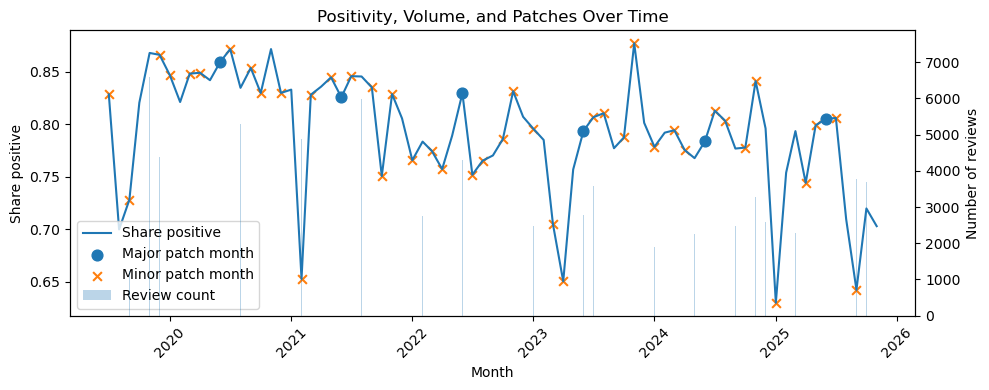

In [17]:
fig, ax1 = plt.subplots(figsize=(10, 4))

# Positivity line
ax1.plot(
    monthly_with_patches["year_month"],
    monthly_with_patches["share_positive"],
    label="Share positive",
)
ax1.set_xlabel("Month")
ax1.set_ylabel("Share positive")

# Review volume as bars on second axis
ax2 = ax1.twinx()
ax2.bar(
    monthly_with_patches["year_month"],
    monthly_with_patches["review_count"],
    alpha=0.3,
    label="Review count",
)
ax2.set_ylabel("Number of reviews")

# Mark major and minor patches on the positivity line
major_mask = monthly_with_patches["major"] > 0
minor_mask = monthly_with_patches["minor"] > 0

ax1.scatter(
    monthly_with_patches.loc[major_mask, "year_month"],
    monthly_with_patches.loc[major_mask, "share_positive"],
    s=60,
    marker="o",
    label="Major patch month",
)

ax1.scatter(
    monthly_with_patches.loc[minor_mask, "year_month"],
    monthly_with_patches.loc[minor_mask, "share_positive"],
    s=40,
    marker="x",
    label="Minor patch month",
)

ax1.tick_params(axis="x", rotation=45)
ax1.set_title("Positivity, Volume, and Patches Over Time")

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc="best")

fig.tight_layout()
plt.show()

### Major and minor months as tables

In [18]:
major_months = monthly_with_patches[monthly_with_patches["major"] > 0][
    ["year_month", "review_count", "share_positive", "major", "minor", "patch"]
].reset_index(drop=True)
major_months

year_month  review_count  share_positive  major  minor  patch
0 2020-06-01          5597        0.859389    1.0    0.0    0.0
1 2021-06-01          5967        0.825708    1.0    0.0    2.0
2 2022-06-01          4306        0.829540    1.0    0.0    2.0
3 2023-06-01          2787        0.793685    1.0    0.0    2.0
4 2024-06-01          2963        0.783665    1.0    0.0    2.0
5 2025-06-01          6195        0.805165    1.0    0.0    1.0

In [19]:
minor_months = monthly_with_patches[monthly_with_patches["minor"] > 0][
    ["year_month", "review_count", "share_positive", "major", "minor", "patch"]
].reset_index(drop=True)
minor_months

year_month  review_count  share_positive  major  minor  patch
0  2019-07-01          2186        0.828454    0.0    1.0    2.0
1  2019-09-01          1225        0.728163    0.0    1.0    1.0
2  2019-12-01          4384        0.866104    0.0    1.0    2.0
3  2020-01-01          4026        0.846746    0.0    1.0    1.0
4  2020-03-01          3847        0.848193    0.0    1.0    2.0
5  2020-04-01          4087        0.849034    0.0    1.0    0.0
6  2020-07-01          5791        0.871525    0.0    1.0    1.0
7  2020-09-01          4999        0.853571    0.0    1.0    2.0
8  2020-10-01          3307        0.829755    0.0    1.0    1.0
9  2020-12-01          4390        0.829841    0.0    1.0    2.0
10 2021-02-01          4876        0.652789    0.0    1.0    2.0
11 2021-03-01          3555        0.828129    0.0    1.0    0.0
12 2021-05-01          4655        0.844683    0.0    1.0    3.0
13 2021-07-01          7503        0.845795    0.0    1.0    0.0
14 2021-09-01          7160        0.835056    0.0    1.0    2.0
15 2021-10-01          6831        0.750695    0.0    1.0    1.0
16 2021-11-01          5903        0.828731    0.0    1.0    1.0
17 2022-01-01          3945        0.765779    0.0    1.0    0.0
18 2022-03-01          2923        0.774547    0.0    1.0    2.0
19 2022-04-01          2489        0.757332    0.0    1.0    0.0
20 2022-07-01          4229        0.751951    0.0    1.0    1.0
21 2022-08-01          3260        0.765337    0.0    1.0    0.0
22 2022-10-01          2588        0.785935    0.0    1.0    2.0
23 2022-11-01          3536        0.831448    0.0    1.0    1.0
24 2023-01-01          2487        0.795738    0.0    1.0    1.0
25 2023-03-01          2972        0.704913    0.0    1.0    2.0
26 2023-04-01          2698        0.650482    0.0    1.0    0.0
27 2023-07-01          3570        0.806723    0.0    1.0    0.0
28 2023-08-01          3135        0.810526    0.0    1.0    3.0
29 2023-10-01          2122        0.787465    0.0    1.0    2.0
30 2023-11-01          4173        0.877067    0.0    1.0    1.0
31 2024-01-01          1910        0.778534    0.0    1.0    1.0
32 2024-03-01          2922        0.794319    0.0    1.0    1.0
33 2024-04-01          2200        0.775455    0.0    1.0    2.0
34 2024-07-01          3368        0.812945    0.0    1.0    2.0
35 2024-08-01          3479        0.803392    0.0    1.0    1.0
36 2024-10-01          2624        0.777820    0.0    1.0    2.0
37 2024-11-01          3278        0.841062    0.0    1.0    0.0
38 2025-01-01          2352        0.630102    0.0    1.0    0.0
39 2025-04-01          2795        0.744186    0.0    1.0    1.0
40 2025-05-01          3095        0.799031    0.0    1.0    2.0
41 2025-07-01          6294        0.806006    0.0    1.0    1.0
42 2025-09-01          3764        0.642402    0.0    1.0    1.0

## 7. Adding mood with a pretrained emotion model

Steam gives us a binary “recommend” flag, but it doesn’t tell us how a review *feels*. Here we use a DistilRoBERTa-based emotion classifier (PyTorch) to label reviews with moods like `joy`, `anger`, `disgust`, `sadness`, `fear`, `neutral`, and `surprise`.

### Load model and tokenizer

In [20]:
tokenizer = AutoTokenizer.from_pretrained(EMOTION_MODEL_NAME)
emotion_model = AutoModelForSequenceClassification.from_pretrained(EMOTION_MODEL_NAME)
emotion_model.eval()

emotion_labels = emotion_model.config.id2label
emotion_labels

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'joy',
 4: 'neutral',
 5: 'sadness',
 6: 'surprise'}

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

### Prepare sample for emotion inference

In [21]:
text_col = "review"  # using the raw review text

# Make sure we only sample from non-empty text
df_for_emotion = df[
    df[text_col].notna()
    & (df[text_col].astype(str).str.strip() != "")
].copy()
df_for_emotion["label"] = df_for_emotion["sentiment"].map({1: "positive", 0: "negative"})


def batched(iterable, batch_size: int):
    batch = []
    for item in iterable:
        batch.append(item)
        if len(batch) == batch_size:
            yield batch
            batch = []
    if batch:
        yield batch


def predict_emotions(texts, batch_size: int = 32, max_len: int = 256):
    all_labels = []
    for batch in batched(texts, batch_size):
        batch_str = [str(t) for t in batch]
        enc = tokenizer(
            batch_str,
            padding=True,
            truncation=True,
            max_length=max_len,
            return_tensors="pt",
        )
        with torch.no_grad():
            outputs = emotion_model(
                input_ids=enc["input_ids"],
                attention_mask=enc["attention_mask"],
            )
            probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()
        preds = probs.argmax(axis=-1)
        all_labels.extend(preds)
    return [emotion_labels[int(i)] for i in all_labels]


emotion_sample = df_for_emotion.sample(EMOTION_SAMPLE_SIZE, random_state=SEED).copy()
emotion_sample["emotion"] = predict_emotions(emotion_sample[text_col])

emotion
joy         0.327125
neutral     0.313713
sadness     0.091025
disgust     0.088887
anger       0.087725
fear        0.061300
surprise    0.030225
Name: proportion, dtype: float64

### Overall mood distribution

In [ ]:
emotion_dist = emotion_sample["emotion"].value_counts(normalize=True)
emotion_dist

### 7.1 Mood vs thumbs-up/down

We compare the emotion labels to Steam’s positive/negative flag. This shows, for example, how many angry or sad reviews still recommend the game.

In [22]:
mood_sent_crosstab = pd.crosstab(
    emotion_sample["emotion"],
    emotion_sample["label"],  # 'positive' / 'negative'
    normalize="index",        # proportions per emotion
).sort_index()

mood_sent_crosstab

label     negative  positive
emotion                     
anger     0.374751  0.625249
disgust   0.558712  0.441288
fear      0.153548  0.846452
joy       0.033856  0.966144
neutral   0.178906  0.821094
sadness   0.364735  0.635265
surprise  0.174938  0.825062

## 8. What different moods actually say

Using the same n-gram helper, we zoom into specific moods: joyful, angry, and disgusted reviews, split by positive vs negative sentiment. This highlights short phrases that characterize each emotional slice.

In [23]:
def top_ngrams_for(df_slice, n: int = 2, k: int = 5, text_col: str = "review"):
    return top_ngrams(df_slice[text_col], n=n, top_k=k)

In [24]:
# Joyful reviews
joy_pos = emotion_sample[
    (emotion_sample["emotion"] == "joy")
    & (emotion_sample["label"] == "positive")
]
joy_neg = emotion_sample[
    (emotion_sample["emotion"] == "joy")
    & (emotion_sample["label"] == "negative")
]

joy_pos_bi = top_ngrams_for(joy_pos, n=2, k=5, text_col=text_col)
joy_neg_bi = top_ngrams_for(joy_neg, n=2, k=5, text_col=text_col)

joy_pos_bi, joy_neg_bi

([('good game', 2778),
  ('fun game', 2549),
  ('great game', 2376),
  ('play friends', 1449),
  ('game play', 1234)],
 [('potato server', 110),
  ('server potato', 109),
  ('fun game', 99),
  ('game fun', 78),
  ('play game', 44)])

In [25]:
# Angry reviews
anger_pos = emotion_sample[
    (emotion_sample["emotion"] == "anger")
    & (emotion_sample["label"] == "positive")
]
anger_neg = emotion_sample[
    (emotion_sample["emotion"] == "anger")
    & (emotion_sample["label"] == "negative")
]

anger_pos_bi = top_ngrams_for(anger_pos, n=2, k=5, text_col=text_col)
anger_neg_bi = top_ngrams_for(anger_neg, n=2, k=5, text_col=text_col)

anger_pos_bi, anger_neg_bi

([('hate game', 661),
  ('play game', 188),
  ('love hate', 181),
  ('hate hate', 170),
  ('help meplease', 160)],
 [('blight nurse', 402),
  ('nurse spirit', 402),
  ('spirit blight', 399),
  ('play game', 232),
  ('hate game', 228)])

In [26]:
# Disgusted reviews
disgust_pos = emotion_sample[
    (emotion_sample["emotion"] == "disgust")
    & (emotion_sample["label"] == "positive")
]
disgust_neg = emotion_sample[
    (emotion_sample["emotion"] == "disgust")
    & (emotion_sample["label"] == "negative")
]

disgust_pos_bi = top_ngrams_for(disgust_pos, n=2, k=5, text_col=text_col)
disgust_neg_bi = top_ngrams_for(disgust_neg, n=2, k=5, text_col=text_col)

disgust_pos_bi, disgust_neg_bi

([('worst game', 190),
  ('game sucks', 131),
  ('dead daylight', 126),
  ('good game', 113),
  ('play game', 90)],
 [('play game', 355),
  ('dead daylight', 234),
  ('game just', 188),
  ('buy game', 184),
  ('playing game', 182)])

## 9. Length, playtime, and positivity per mood

Here we look at how long each mood’s reviews are, how many minutes those players have, and how often they recommend the game. It’s a compact way to see which moods come from high-hour, essay-writing veterans vs short early impressions.

In [27]:
emotion_sample["text_len"] = emotion_sample[text_col].astype(str).str.len()

emotion_stats = (
    emotion_sample
    .groupby("emotion")
    .agg(
        mean_len=("text_len", "mean"),
        median_len=("text_len", "median"),
        mean_playtime_min=("author_playtime_at_review_min", "mean"),
        median_playtime_min=("author_playtime_at_review_min", "median"),
        share_positive=("label", lambda s: (s == "positive").mean()),
        count=("emotion", "size"),
    )
    .sort_index()
)

emotion_stats

mean_len  median_len  mean_playtime_min  median_playtime_min  \
emotion                                                                    
anger     210.928755        64.0       23646.589627               8331.0   
disgust   314.312474        74.0       27524.477289              10191.0   
fear      284.043638        88.0       15582.952080               3415.5   
joy        96.235002        38.0       12691.102828               3009.0   
neutral   137.392676        14.0       17632.386500               4278.0   
sadness   164.173441        49.0       22363.406482               7116.0   
surprise  142.574442        37.0       15626.959057               3584.5   

          share_positive  count  
emotion                          
anger           0.625249   7018  
disgust         0.441288   7111  
fear            0.846452   4904  
joy             0.966144  26170  
neutral         0.821094  25097  
sadness         0.635265   7282  
surprise        0.825062   2418

## 10. A tiny killer case study (Blight, Nurse, Spirit)

To show how to focus on specific topics, we flag reviews that mention three killers: Blight, Nurse, and Spirit. Then we look at how many reviews mention them, how positive those reviews are, and what moods they’re written in.

In [28]:
killer_cols = {
    "blight": r"\bblight\b",
    "nurse": r"\bnurse\b",
    "spirit": r"\bspirit\b",
}

for name, pattern in killer_cols.items():
    df[f"mentions_{name}"] = df["review"].astype(str).str.contains(
        pattern, case=False, na=False
    )

for name, pattern in killer_cols.items():
    emotion_sample[f"mentions_{name}"] = (
        emotion_sample[text_col]
        .astype(str)
        .str.contains(pattern, case=False, na=False)
    )

emotion_sample[
    ["emotion", "label", "mentions_blight", "mentions_nurse", "mentions_spirit"]
].head()

emotion     label  mentions_blight  mentions_nurse  mentions_spirit
47707   disgust  negative            False           False            False
201447      joy  positive            False           False            False
262638  neutral  positive            False           False            False
38958   neutral  positive            False           False            False
210739  sadness  negative            False           False            False

In [29]:
def killer_summary(killer: str):
    mask = emotion_sample[f"mentions_{killer}"]
    subset = emotion_sample[mask]
    return {
        "killer": killer,
        "n_reviews": len(subset),
        "share_of_sample": len(subset) / len(emotion_sample),
        "share_positive": (subset["label"] == "positive").mean(),
        "mood_dist": subset["emotion"].value_counts(normalize=True),
    }


for k in ["blight", "nurse", "spirit"]:
    print(killer_summary(k))

{'killer': 'blight', 'n_reviews': 186, 'share_of_sample': 0.002325, 'share_positive': np.float64(0.521505376344086), 'mood_dist': emotion
neutral     0.317204
disgust     0.204301
sadness     0.123656
joy         0.123656
anger       0.107527
fear        0.086022
surprise    0.037634
Name: proportion, dtype: float64}
{'killer': 'nurse', 'n_reviews': 390, 'share_of_sample': 0.004875, 'share_positive': np.float64(0.541025641025641), 'mood_dist': emotion
neutral     0.269231
disgust     0.187179
anger       0.156410
sadness     0.133333
joy         0.117949
fear        0.087179
surprise    0.048718
Name: proportion, dtype: float64}
{'killer': 'spirit', 'n_reviews': 232, 'share_of_sample': 0.0029, 'share_positive': np.float64(0.6939655172413793), 'mood_dist': emotion
neutral     0.331897
joy         0.189655
disgust     0.172414
anger       0.103448
sadness     0.099138
fear        0.064655
surprise    0.038793
Name: proportion, dtype: float64}


## 11. Killer “drama arcs” over time

Finally, we build monthly sentiment curves for reviews that mention each killer. This gives a small, spiky “drama arc” per killer, which you can compare to patch history or other events.

In [32]:
def killer_monthly(killer: str):
    mask = df[f"mentions_{killer}"]
    subset = df[mask]
    monthly_k = (
        subset.groupby("year_month")
        .agg(
            review_count=("review", "size"),
            share_positive=("sentiment", "mean"),
        )
        .reset_index()
    )
    monthly_k["killer"] = killer
    return monthly_k


killer_monthly_df = pd.concat(
    [killer_monthly(k) for k in ["blight", "nurse", "spirit"]],
    ignore_index=True,
)

killer_monthly_df.head(), killer_monthly_df["killer"].value_counts()

(  year_month  review_count  share_positive  killer
 0 2019-07-01             4        0.250000  blight
 1 2019-08-01             3        0.666667  blight
 2 2019-09-01             4        0.500000  blight
 3 2019-10-01             2        0.500000  blight
 4 2019-11-01             6        0.666667  blight,
 killer
 nurse     77
 spirit    77
 blight    76
 Name: count, dtype: int64)

### Example: Nurse's sentiment over time

In [33]:
k = "nurse"
km = killer_monthly_df[killer_monthly_df["killer"] == k].sort_values("year_month")

km[["year_month", "review_count", "share_positive"]].head(), km[
    ["year_month", "review_count", "share_positive"]
].tail()

(   year_month  review_count  share_positive
 76 2019-07-01            19        0.631579
 77 2019-08-01            11        0.454545
 78 2019-09-01             8        0.625000
 79 2019-10-01            15        0.466667
 80 2019-11-01            23        0.608696,
     year_month  review_count  share_positive
 148 2025-07-01            38        0.552632
 149 2025-08-01            33        0.454545
 150 2025-09-01            22        0.363636
 151 2025-10-01            25        0.520000
 152 2025-11-01             3        0.333333)

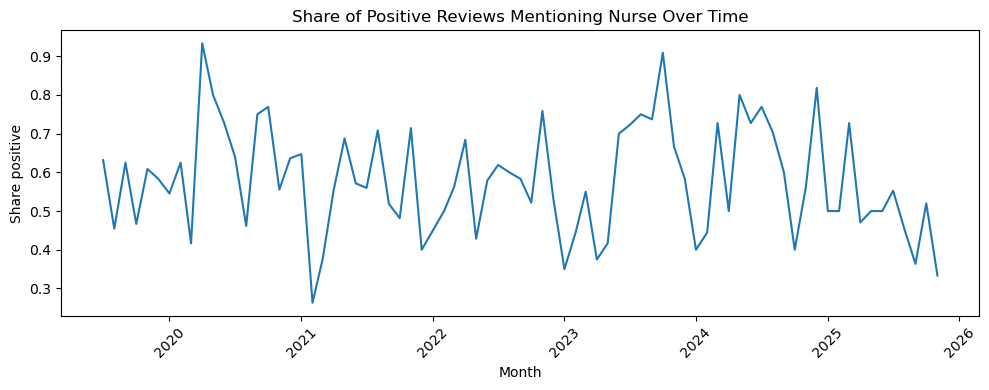

In [31]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(km["year_month"], km["share_positive"])
ax.set_title(f"Share of Positive Reviews Mentioning {k.capitalize()} Over Time")
ax.set_xlabel("Month")
ax.set_ylabel("Share positive")
ax.tick_params(axis="x", rotation=45)

fig.tight_layout()
plt.show()

## Where to go next

This notebook is meant as a starting point. You can:
- train your own sentiment or emotion models on this data,
- study “helpful” or “funny” votes instead of thumbs-up/down,
- compare free vs paid players,
- or focus on other killers, perks, or patches you care about.

Feel free to fork, edit, and build your own Dead by Daylight NLP experiments on top of this.